In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, boxcox, probplot
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import matplotlib
import os
print(os.listdir("../input"))

train = pd.read_csv('../input/data_train.csv')
train['train'] = 1
test = pd.read_csv('../input/data_test.csv')
test['train'] = 0
data = pd.concat([train,test],axis=0).reset_index(drop=True)


['data_train.csv', 'data_test.csv']


In [2]:
def ConnectTrainAndTestWithLabeling(training_set_path, test_set_path):
    train = pd.read_csv(training_set_path)
    train['train'] = 1
    test = pd.read_csv(test_set_path)
    test['train'] = 0
    train.append(test, ignore_index=True)
    return train, test, data

train, test, data = ConnectTrainAndTestWithLabeling('../input/data_train.csv', '../input/data_test.csv')

In [3]:
%%time
len(test.hash.unique())

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 20.3 ms


33515

Opis poszczególnych zmiennych:

a) hash - reprezentuje ID danego urządzenia. ID to zmienia się co 24 godziny w związku z czym niemożliwym jest namierzenie tego samego urządzenia innego dnia

b) trajectory_id - ID trajektorii użytkownika urządzenia lokalizującego. Trajektorią nazywamy ruch urządzenia lokalizującego z punktu A do B. 

c) time_entry - godzina rozpoczęcia rejestrowania danej trajektorii

d) time_exit - godzina zakończenia rejestrowania danej trajektorii

e) Vmax - prędkość maksymalana z jaką poruszało się urządzenie w danej trajektorii

f) Vmin - prędkość minimalna z jaką poruszało się urządzenie w danej trajektorii

g) Vmean - prędkość średnia z jaką poruszało się urządzenie w danej trajektorii

h) x_entry - koordynat x na początku trajektorii na płaszczyźnie kartezjańskiej

i) y_entry - koordynat y na początku trajektorii na płaszczyźnie kartezjańskiej

j) x_exit - koordynat x na końcu trajektorii na płaszczyźnie kartezjańskiej

k) y_exit - koordynat y na końcu trajektorii na płaszczyźnie kartezjańskiej

W problemie należy określić, czy dane urządzenie będzie między godziną 15 a 16 w centrum miasta. Centrum miasta jest określone następującymi koordynatami:

* 3750901.5068 ≤ 𝑥 ≤ 3770901.5068
* −19268905.6133 ≤ 𝑦 ≤ −19208905.6133

Trajektorie są jedynie UPROSZCZENIEM drogi poruszania się danego urządzenia. Trajektoria łączy punkt startowy z punktem końcowym. Urządzenie mogło się poruszać po linii innej niż prosta.

Zdefiniujmy funkcję right i left, która będzie wyciągała odpowiednią liczbę znaków z zadanego stringa z odpowiedniej strony.
Następnie utworzymy zmienną traj, która każdemu przypadkowi przypisze numer trajektorii. 

**Czy możemy tą zmienną zamienić zmienną trajectory_id? Będzie przejrzyściej**

Numery trajektorii nie zawsze są "ciągłe", czasami po numerze 1 następuje trajektoria numer 3.

In [4]:
def CreateDistanceVariable(data):
    data['distance_cart'] = np.sqrt(((data.x_entry - data.x_exit)**2) + ((data.y_entry - data.y_exit)**2))
    return data

data = CreateDistanceVariable(data)

Z uwagi na fakt, że nie możemy w łatwy sposób przekonwertować jednostek z płaszczyzny kartezjańskiej na kilometry, to zdecydowaliśmy się na utworzenie zmiennej określającej prędkość pokonania danej trajektorii w jednostkach kartezjańskich na godzinę. Zmienna ta zostanie utworzona za pomocą zmiennej pomocniczej określającej czas trwania danej trajektorii.

In [5]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_entry_seconds'] = data.time_entry.map(lambda x: x.total_seconds())
data['time_exit'] = pd.to_timedelta(data.time_exit)
data['time_exit_seconds'] = data.time_exit.map(lambda x: x.total_seconds())

data['traj_time'] = data['time_exit_seconds'] - data['time_entry_seconds']
data['traj_time'] = data['traj_time']/3600

data['vmean_cart'] = data['distance_cart'] / data['traj_time']

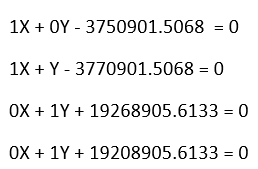

Dodatkowo, aby obliczyć dystans do City Center skorzystamy ze wzoru poniżej. Dla każdego punktu będą liczone 4 dystanse. Wybrany zostanie dystans najmniejszy, chyba że dany punkt znajduje się w City Center. W takim wypadku zmienna otrzyma 0

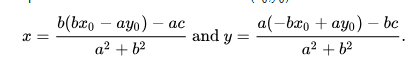

In [6]:
x = data.x_exit
y = data.y_exit
a1 = 1
b1 = 0
c1 = -3750901.5068  
a2 = 1
b2 = 0
c2 = -3770901.5068
a3 = 0
b3 = 1
c3 = 19268905.6133
a4 = 0
b4 = 1
c4 = 19208905.6133

Powyżej zapisane zostały parametry odpowiadające każdej z prostych. Następnym krokiem będzie juz stworzenie odpowiedniej kolumny. Sposób postępowania jest następujący - oblicz minimalny dystans od danego punktu do każdej z prostych a spośród tych dystansów wybierz najmniejszy. Jeżeli jednak dany punkt znajduje się jednocześnie między wszystkimi prostymi to w takim wypadku przypisz mu dystans równy 0.

Zmienne a, b, c, d odpowiadają dystansom do odpowiednich prostych 1,2,3,4 (opisane powyżej).

In [7]:
a = np.sqrt(((b1*(b1*data.x_entry-a1*data.y_entry)-a1*c1)/(a1**2+b1**2) - data.x_entry)**2 + ((a1*(-b1*data.x_entry+a1*data.y_entry)-b1*c1)/(a1**2+b1**2) - data.y_entry)**2)
b = np.sqrt(((b2*(b2*data.x_entry-a2*data.y_entry)-a2*c2)/(a2**2+b2**2) - data.x_entry)**2 + ((a2*(-b2*data.x_entry+a2*data.y_entry)-b2*c2)/(a2**2+b2**2) - data.y_entry)**2)
c = np.sqrt(((b3*(b3*data.x_entry-a3*data.y_entry)-a3*c3)/(a3**2+b3**2) - data.x_entry)**2 + ((a3*(-b3*data.x_entry+a3*data.y_entry)-b3*c3)/(a3**2+b3**2) - data.y_entry)**2)
d = np.sqrt(((b4*(b4*data.x_entry-a4*data.y_entry)-a4*c4)/(a4**2+b4**2) - data.x_entry)**2 + ((a4*(-b4*data.x_entry+a4*data.y_entry)-b4*c4)/(a4**2+b4**2) - data.y_entry)**2)

dod = pd.concat([a,b,c,d],axis=1).min(axis=1)
data = pd.concat([data,dod],axis=1)
data = data.rename(columns={0:'DistanceFromCCentry'})

data['IsInCCentry'] = pd.Series(np.where((data.x_entry>=3750901.5068) & (data.x_entry<=3770901.5068) & (data.y_entry>=-19268905.6133) & (data.y_entry<=-19208905.6133),1,0))
data['DistanceFromCCentry'] = pd.Series(np.where(data.IsInCCentry==1,0, data['DistanceFromCCentry']))

Następnie dokonamy podobnej transformacji z punktami exit, aby pokazać czy dane urządzenie zbliżyło się do centrum w danej trajektorii. 

In [8]:
a = np.sqrt(((b1*(b1*data.x_exit-a1*data.y_exit)-a1*c1)/(a1**2+b1**2) - data.x_exit)**2 + ((a1*(-b1*data.x_exit+a1*data.y_exit)-b1*c1)/(a1**2+b1**2) - data.y_exit)**2)
b = np.sqrt(((b2*(b2*data.x_exit-a2*data.y_exit)-a2*c2)/(a2**2+b2**2) - data.x_exit)**2 + ((a2*(-b2*data.x_exit+a2*data.y_exit)-b2*c2)/(a2**2+b2**2) - data.y_exit)**2)
c = np.sqrt(((b3*(b3*data.x_exit-a3*data.y_exit)-a3*c3)/(a3**2+b3**2) - data.x_exit)**2 + ((a3*(-b3*data.x_exit+a3*data.y_exit)-b3*c3)/(a3**2+b3**2) - data.y_exit)**2)
d = np.sqrt(((b4*(b4*data.x_exit-a4*data.y_exit)-a4*c4)/(a4**2+b4**2) - data.x_exit)**2 + ((a4*(-b4*data.x_exit+a4*data.y_exit)-b4*c4)/(a4**2+b4**2) - data.y_exit)**2)

dod = pd.concat([a,b,c,d],axis=1).min(axis=1)
data = pd.concat([data,dod],axis=1)
data = data.rename(columns={0:'DistanceFromCC'})

data['IsInCC'] = pd.Series(np.where((data.x_exit>=3750901.5068) & (data.x_exit<=3770901.5068) & (data.y_exit>=-19268905.6133) & (data.y_exit<=-19208905.6133),1,0))
data['DistanceFromCC'] = pd.Series(np.where(data.IsInCC==1,0, data['DistanceFromCC']))

Zmienna closetoCC będzie opisywała, czy urządzenie w punkcie exit jest bliżej centrum niż w punkcie entry.

In [9]:
data['hashSHIFT-1'] = data.hash.shift(-1)
data['closetoCC'] = pd.Series(np.where((data.DistanceFromCCentry > data.DistanceFromCC) & (data.hash == data['hashSHIFT-1']),1,0))

Następnym krokiem będzie przekonwertowanie zmiennej godzina w taki sposób, aby stanowiła ona informację o tym, ile czasu jeszcze zostało aż do deadlineu (godziny między 15 a 16).

In [10]:
data['TimeTillDeadline'] = (54000 - data.time_exit_seconds)/3600
data['TimeTillDeadline'] = data.TimeTillDeadline.map(lambda x: 0 if x<0 else x)

Następnie postaramy się uzupełnić łatwe to uzupełnienia NaNy. Jeżeli dany obiekt nie zmienił swojego położenia w czasie danej trajektorii, wtedy jego trajektorią jest punkt. W związku z tym możemy założyć, że jego prędkość wynosi 0. 

In [11]:
data.vmean_cart[(data.x_entry==data.x_exit) & (data.y_entry==data.y_exit)] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Dodatkowo, należy również zwrócić uwagę na całkowity brak jakiejkolwiek miarodajności danych dotyczących prędkości poruszania się danego urządzenia. Przykład poniżej:
    
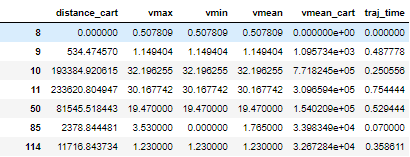

Obserwacja numer 114 ma bardzo podobną prędkość do obserwacji nr 9, jednak jeśli spojrzymy na zmienną vmean_cart okazuje się, że prawdziwa prędkość przy obserwacji 114 jest około 30 krotnie wyższa. W związku z powyższym należy usunąć te zmienne.

In [12]:
data = data.drop(['vmax','vmin','vmean'],axis=1)

Kolejnym problemem w rozpatrywanym zbiorze danych są oberwacje 'teleportacyjne', czyli takie gdzie w czasie danej trajektorii urządzenie pokonuje dystans, jednak czas się nie zmienia. Problemem podobnym są również trajektorie w czasie których urządzenie pokonuje bardzo duży dystans w bardzo krótkim czasie. W celu korekty tych obserwacji podjęte zostaną następującve działania:
* Transformacja zmiennej <i>vmean_car</i> na zgodną z rozkładem normalnym
* W oparciu o powyższą zmienną w obserwacjach teleportacyjnych prędkości i czas podróży zostaną zastąpione racjonalnymi wartościami. Takie samo postępowanie będzie miało miejsce w przypadku wartości w których stosunek dystansu do prędkości jest zbyt duży

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


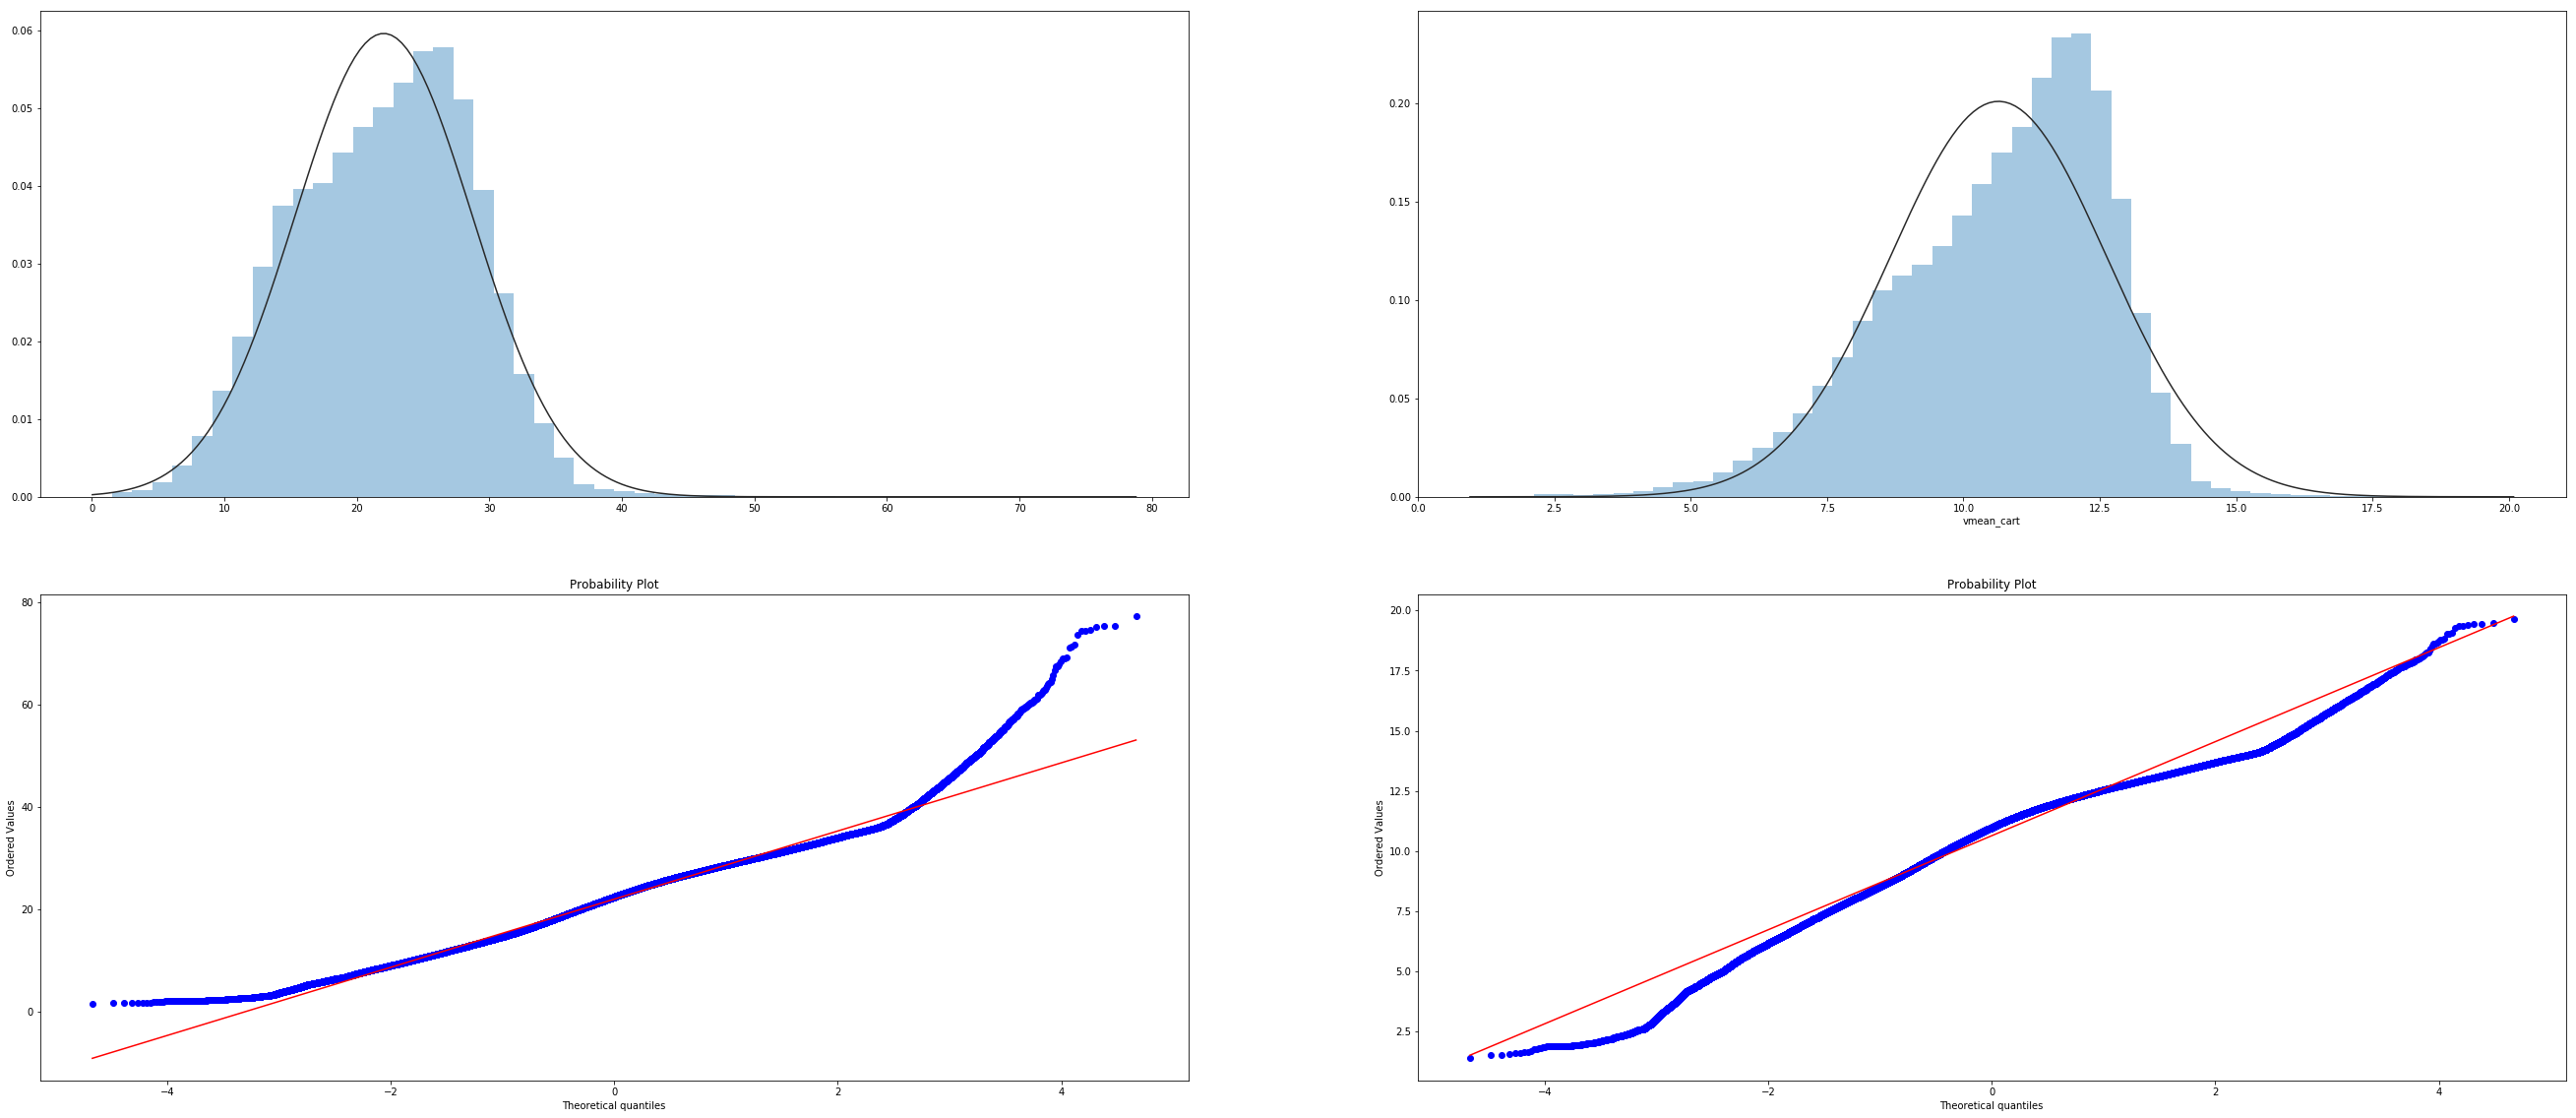

In [13]:
data['Hour'] = data.time_entry.map(lambda x: round(x.total_seconds()/3600,0))
fit, axarr = plt.subplots(2,2,figsize=(46,20))
sns.distplot(boxcox(data.vmean_cart[(data.vmean_cart>0) & (data.vmean_cart<np.Inf)])[0],ax=axarr[0][0],kde=False,fit=norm)
sns.distplot(np.log(data.vmean_cart[(data.vmean_cart>0) & (data.vmean_cart<np.Inf)]),ax=axarr[0][1],kde=False,fit=norm)
probplot(boxcox(data.vmean_cart[(data.vmean_cart>0) & (data.vmean_cart<np.Inf)])[0],plot=axarr[1][0])
probplot(np.log(data.vmean_cart[(data.vmean_cart>0) & (data.vmean_cart<np.Inf)]),plot=axarr[1][1])
data['vmean_cartLOG'] = np.log(data.vmean_cart)

Jeżeli spojrzeć na histogramy, to transformacja Boxa Coxa zdaje się bardziej pasować do rozkładu normalnego, jednak jezeli spojrzymy na wykres kwantyl kwantyl to transformacja logarytmem zdaje się lepiej wpływać na normalizację rozkładu. Dodatkowo podjęta została próba dopasowania innej transformacji dla średnich prędkości kartezjańskich o danych godzinach, jednak takie przekształcenia nie spisywały się lepiej niż transformacja logarytmem całej zmiennej

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


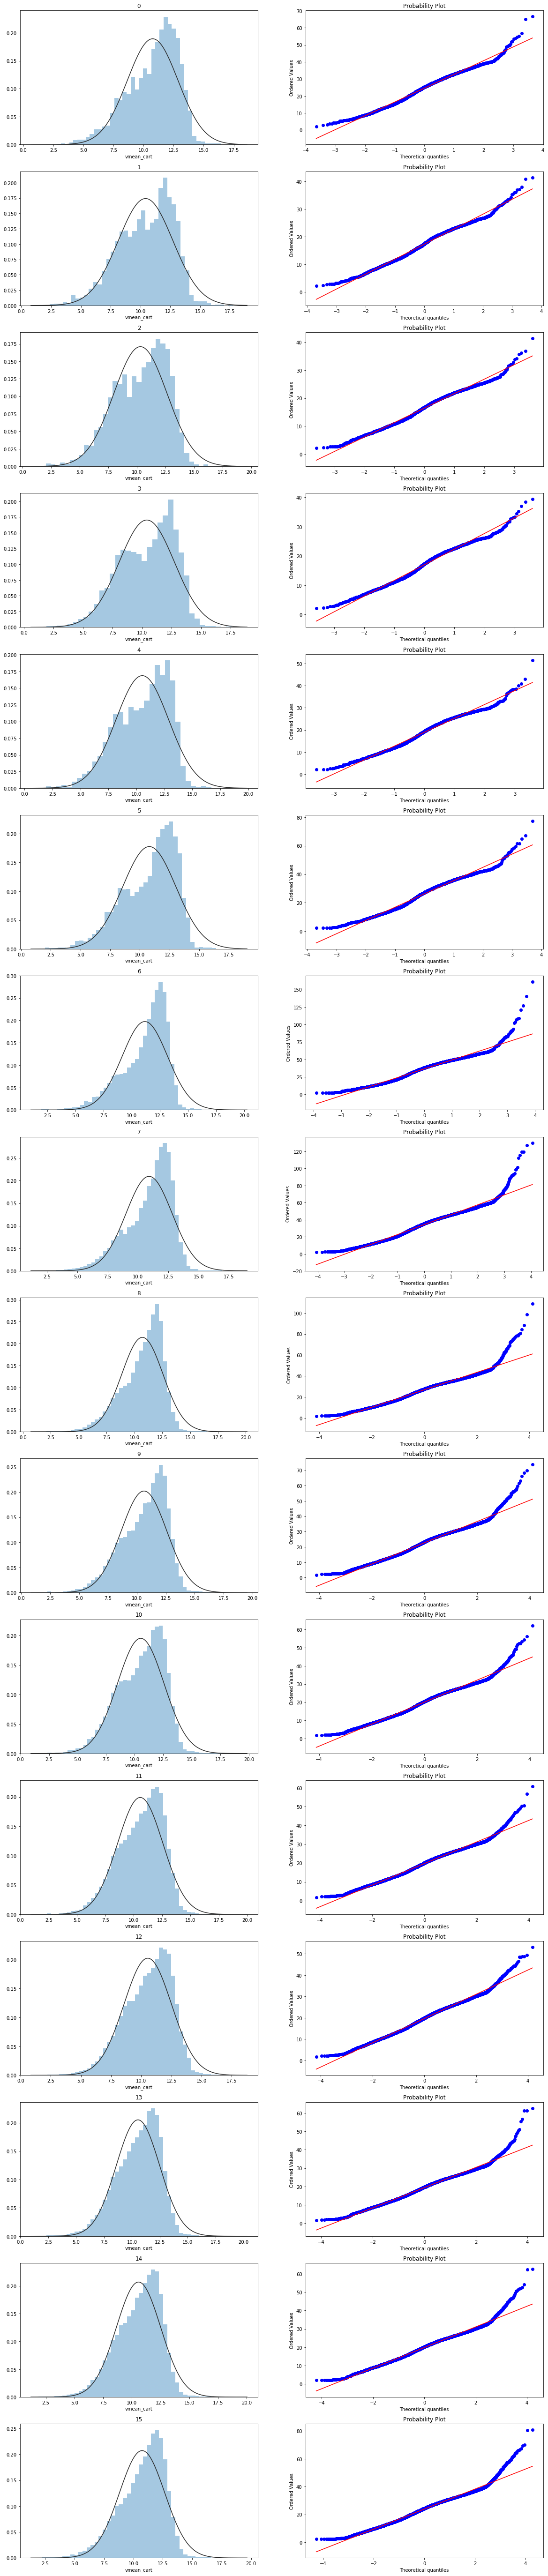

In [14]:
fit, axarr = plt.subplots(16,2,figsize=(20,100))
for i in range(16):
    sns.distplot(np.log(data.vmean_cart[(data.vmean_cart>0) & (data.vmean_cart<np.Inf) & (data.Hour==i)]),ax=axarr[i][0],kde=False,fit=norm).set_title('{}'.format(i))
    probplot(boxcox(data.vmean_cart[(data.vmean_cart>0) & (data.vmean_cart<np.Inf) & (data.Hour==i)])[0],plot=axarr[i][1])

data['Hour'] = data.time_exit.map(lambda x: int(x.total_seconds()/3600))
data.time_exit[(data.Hour==16)] = data.time_exit[(data.Hour==16)]-datetime.timedelta(seconds=1)
data['Hour'] = data.time_exit.map(lambda x: int(x.total_seconds()/3600))


W wyniku powyższej operacji pojawiły nam się ujemne nieskończoności. Możnaby je po prostu zamienić na zera, jednak wtedy rozkład stanie się jeszcze bardziej rozbieżny z normalnym. W związku z tym do danych zaimplementowane zostanie następujące działanie:

n - numer obserwacji

Jeżeli y_entry oraz x_entry dla n == y_exit oraz x_exi dla n-1 == y_entry oraz x_entry dla n+1 to usuń obserwacje n. 

W wypadku spełnienia powyższego warunku obserwacja n nie wnosi żadnej istotnej informacji dotyczącej położenia urządzenia.

In [15]:
data['hashSHIFT1'] = data.hash.shift(1)
data['y_exitSHIFT1'] = data.y_exit.shift(1)
data['x_exitSHIFT1'] = data.x_exit.shift(1)
data['y_entrySHIFT-1'] = data.y_entry.shift(-1)
data['x_entrySHIFT-1'] = data.x_entry.shift(-1)

a = (data.hashSHIFT1==data['hashSHIFT-1']) & (data.x_entry==data.x_exitSHIFT1) & (data.x_entry==data['x_entrySHIFT-1']) & (data.y_entry==data.y_exitSHIFT1) & (data.y_entry==data['y_entrySHIFT-1'])
data = data.drop(a[a==True].index,axis=0).reset_index(drop=True)

# data = data.drop(['y_entrySHIFT-1','x_entrySHIFT-1'],axis=1)

Powyższe dzałanie pozwoliło nam na usuniecie około 600 obserwacji, jednak w dalszym ciągu mamy sporo wartości nieskończonych. Pojawiają się one również w miejscach, gdzie następuje przemieszczenie między trajektoriami, a w samych trajektoriach żaden ruch nie ma miejsca. Następujące rozwiązanie:

* Utworzona zostanie zmienna pomocnicza wskazująca czy między odpowiednimi trajektoriami miał miejsce jakiś ruch (a więc czy jest różnica odległości między punktem startowym obserwacji n a punktem końcowym obserwacji n-1). Będziemy również tworzyć zmienną która sprawdzi, czy nastąpił ruch między daną trajektorią a jej następnikiem
* W wypadkach gdzie taki ruch miał miejsce, oraz gdzie wartość vmean_cartLOG = -inf czas trwania trajektorii (time_entry), distance_cart, vmean_cart zostaną odpowiednio wydłużone

Transformacja ta będzie miała miejsce jedynie w przypadku vmean_cartLOG = -inf, ponieważ nie chcemy wprowadzać tego dyskusyjnego podejścia w ilościach większych niż to konieczne. Należy pamiętać, że głównym celem tej operacji jest pozbycie się -inf oraz zer ze zmiennych vmean_cartLOG oraz vmean_cart. Oczywiście efektem ubocznym (aczkolwiek pożądanym) będzie również zmiana dystansu na większy od zera w distance_cart.

Time_entry będzie zaktualizowane. Wartości time_entry których obserwacje spełniają powyższy warunek zostaną cofnięte do tyłu. Alternatywnie można przesunąć do przodu time_exit, jednak w takim wypadku mogłoby dochodzić do sytuacji w których time_exit danej obserwacji nachodziłby do godzin między 15 a 16.

In [16]:
data['MoveBetweenTraj1'] = pd.Series(np.where(((data.y_exitSHIFT1!=data.y_entry) | (data.x_exitSHIFT1!=data.x_entry)) & (data.hash==data.hashSHIFT1) & (data.vmean_cartLOG==-np.Inf),\
                                           np.sqrt((data.y_exitSHIFT1-data.y_entry)**2+(data.x_exitSHIFT1-data.x_entry)**2),0))

data['MoveBetweenTraj-1'] = pd.Series(np.where(((data['y_entrySHIFT-1']!=data.y_exit) | (data['x_entrySHIFT-1']!=data.x_exit)) & (data.hash==data['hashSHIFT-1']) & (data.vmean_cartLOG==-np.Inf),\
                                             np.sqrt((data['y_entrySHIFT-1']-data.y_exit)**2+(data['x_entrySHIFT-1']-data.x_exit)**2),0))

In [17]:
# data[(data.MoveBetweenTraj1>0) & (data['MoveBetweenTraj-1']>0)][data.distance_cart] =data[['MoveBetweenTraj1','MoveBetweenTraj-1']][(data.MoveBetweenTraj1>0) & (data['MoveBetweenTraj-1']>0)].sum(axis=1)
data['x_entry'] = np.where((data.MoveBetweenTraj1>0) & (data['MoveBetweenTraj-1']>0),data.x_exitSHIFT1,data['x_entry'])
data['y_entry'] = np.where((data.MoveBetweenTraj1>0) & (data['MoveBetweenTraj-1']>0),data.y_exitSHIFT1,data['y_entry'])
data['x_exit'] = np.where((data.MoveBetweenTraj1>0) & (data['MoveBetweenTraj-1']>0),data['x_entrySHIFT-1'],data['x_exit'])
data['y_exit'] = np.where((data.MoveBetweenTraj1>0) & (data['MoveBetweenTraj-1']>0),data['y_entrySHIFT-1'],data['y_exit'])

data.distance_cart[(data.MoveBetweenTraj1>0) & (data['MoveBetweenTraj-1']>0)] = data[['MoveBetweenTraj1','MoveBetweenTraj-1']].sum(axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [18]:
data['x_entry'] = np.where((data.MoveBetweenTraj1>0),data.x_exitSHIFT1,data['x_entry'])
data['y_entry'] = np.where((data.MoveBetweenTraj1>0),data.y_exitSHIFT1,data['y_entry'])

data.distance_cart[(data.MoveBetweenTraj1>0)] = data['MoveBetweenTraj1']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
data['x_exit'] = np.where((data['MoveBetweenTraj-1']>0),data['x_entrySHIFT-1'],data['x_exit'])
data['y_exit'] = np.where((data['MoveBetweenTraj-1']>0),data['y_entrySHIFT-1'],data['y_exit'])

data.distance_cart[data['MoveBetweenTraj-1']>0] = data['MoveBetweenTraj-1']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Żeby dowiedzieć się jakie wartości najlepiej byłoby wstawić w miejsce prędkości utworzymy wykres słupkowy ze skategoryzowaną zmienną dystansu, oraz prędkością. Takie działanie wywołane jest założeniem, że im dalej dana osoba się przemieszcza tym szybciej chce pokonać zadany dystans

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


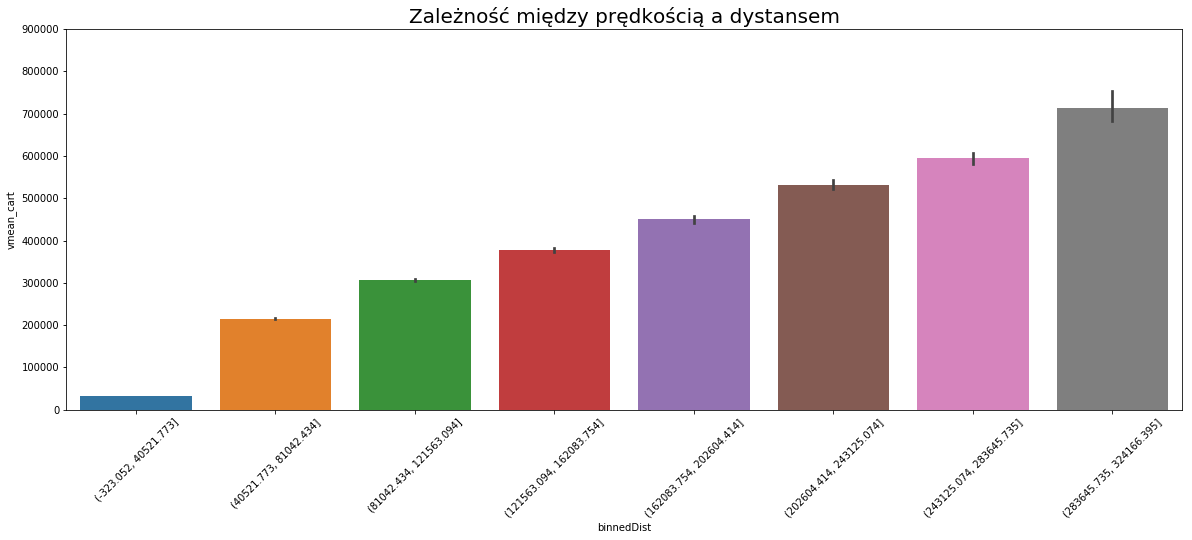

In [20]:
databinned = data[['distance_cart','vmean_cart']]
databinned = databinned[(databinned.vmean_cart>0) & (databinned.vmean_cart<np.Inf) & (databinned.distance_cart>0)]
databinned['binnedDist'] = pd.cut(databinned.distance_cart,bins=8)


fig, axarr = plt.subplots(figsize=(20,7))
# matplotlib.axes.Axes.set_yticks(ticks=[1,2,3,4], minor=False)
plt.xticks(rotation=45)

plt.title('Zależność między prędkością a dystansem',fontsize=20)
sns.barplot(data=databinned,x='binnedDist', y='vmean_cart',estimator=np.median).set_yticks(ticks=range(100000,1000000,100000), minor=True)


W oparciu o powyższy wykres w odpowiednie pola zostanie wpisana mediana z przedziałów. Warto również podkerślić że mamy do czynienia z silną korelacją między skategoryzowanym dystansem, a prędkościom. Liczba binów (słupków) została dobrana tak, aby uwidocznić stale rosnącą prędkość przy a jedncześnie podzielić distance_cart na jak najwięcej przedziałów.
Dokładne wartości median dla poszczególnych przedziałów są następujące:

In [21]:
means = databinned[['binnedDist','vmean_cart']].groupby('binnedDist').median()
means

,vmean_cart
binnedDist,
"(-323.052, 40521.773]",31820.637092
"(40521.773, 81042.434]",215465.984579
"(81042.434, 121563.094]",307090.805093
"(121563.094, 162083.754]",378025.986844
"(162083.754, 202604.414]",451291.986950
"(202604.414, 243125.074]",531717.498246
"(243125.074, 283645.735]",594663.277471
"(283645.735, 324166.395]",713615.446486


Obecnie posiadamy juz wszystkie potrzebne informacji do wykonania imputacji:

* Dystans - wartości zmiennej MoveBetweenTraj w odpowiednich miejscach (patrz wyżej 'odpowiednie miejsca')
* Prędkość - mediany dla poszczególnyh przedziałów dystansu
* Czas - iloraz prędkości i dystansu


In [22]:
for i in range(len(means)):
    data.vmean_cart[(data.distance_cart<=means.index[i].right) & (data.distance_cart>means.index[i].left) & (data.distance_cart>0) & (data.vmean_cart==0)] = means.vmean_cart.iloc[i]
    
data.vmean_cartLOG = np.log(data.vmean_cart)
data.traj_time = data.distance_cart / data.vmean_cart

timedelta = pd.to_timedelta(data.traj_time,unit='h').map(lambda x: x.total_seconds()/3600)
data.time_entry = [data.time_entry[i] - datetime.timedelta(hours=timedelta[i]) if (data.MoveBetweenTraj1[i]>0 or data['MoveBetweenTraj-1'][i]>0) else data.time_entry[i] for i in range(len(data))] 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Podobnie będziemy postępować w przypadku obserwacji, w których nie zmienia się czas, ale położenie punktu entry i exit jest inne. W zmiennej vmean_cartLOG znajdują się wartości Inf.

Dodamy  zmienną 'teleportation', która określi nam wartością 1 problematyczne przypadki.

Skorzystamy ze zmiennej podobnej do zmiennej means, jednak przedziały dystansu będą dostosowane do wartości maksymalnej wśród przypadków dla których teleportation = 1.

In [23]:
data['teleportation'] = np.where((((data.x_exit!=data.x_entry) | (data.y_exit!=data.y_entry)) & (data.time_entry==data.time_exit)),1,0)

Skorzystamy teraz z modyfiakcji wcześniejszego kodu, która odejmie odpowiedni czas od zmiennej time_entry.

Na początku dodajmy zmienną target i przypiszmy 1 linijkom, które są w zbiorze testowym i wymagają od nas obliczenia punktów exit.

In [24]:
data['target'] = pd.Series(np.where((data.train==0) & (data.x_exit.isnull()==True),1,0))
data[data.target==1].head()
print('Mean dla teleportacji:', data.distance_cart[data.teleportation==1].mean())
print('Median dla teleportacji:', data.distance_cart[data.teleportation==1].median())
print('Mean ogółem:', data.distance_cart.mean())
print('Median ogółem:', data.distance_cart.median())

data = data.drop('teleportation',axis=1)

Mean dla teleportacji: 693.6523480236342
Median dla teleportacji: 157.3715765976943
Mean ogółem: 19982.340710714765
Median ogółem: 2521.883277869231


Następnie przypiszmy brakujące wartości zmiennej vmean_cart na podstawie median dystansów obliczonych wcześniej oraz "cofnijmy" czas entry o odpowiednią liczbę sekund. Jedak zanim to zrobimy to należy zwrócić uwagę z jak dużymi różnicami w przebywanych odległościach mamy do czynienia między odpowiednimi miarami dla zmiennych teleportacyjnych w stosunku do całej próby. Mediana dla obserwacji teleportacyjnych jest około 10 razy mniejsza od mediany próbym podczas gdy średnia jest 30 krotnie mniejsza. W związku z tym proponowane są dwa podejścia:

* Utworzenie osobnych kategorii zmiennej distance_cart wraz ze średnią prędkością vmean_cart, jednak tym razem kategoria z największym dystansem będzie dostosowana do największych dystansów obserwacji teleportacyjnych. Dodatkowo, aby upewnić się że średnie nie są liczone ze zbyt małej ilości obserwacji dodana zostanie zmienna SampleSize
* Potraktowanie obserwacji teleportacyjnych jako wartości odstające i usunięcie ich z analizy
* Potraktowanie obserwacji teleportacyjnych jako błąd pomiaru GPS i korekta x_exit oraz y_exit na równy punktom entry. W takim wypadku distance_cart należy zamienić na 0

Na razie zastosujemy podejście nr 1, jednak pozostałe podejścia będą prawdopodobnie testowane w ramach model tuningu.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,vmean_cart,SampleSize
binnedDist,,
"(-12.886, 561.068]",2393.087392,78976
"(561.068, 1121.022]",8275.911566,37112
"(1121.022, 1680.977]",14369.363938,21853
"(1680.977, 2240.931]",19804.737500,15453
"(2240.931, 2800.885]",24434.165719,12608
"(2800.885, 3360.84]",29307.245098,10630
"(3360.84, 3920.794]",33006.452533,9220
"(3920.794, 4480.749]",37497.509463,8041
"(4480.749, 5040.703]",41860.231960,7201


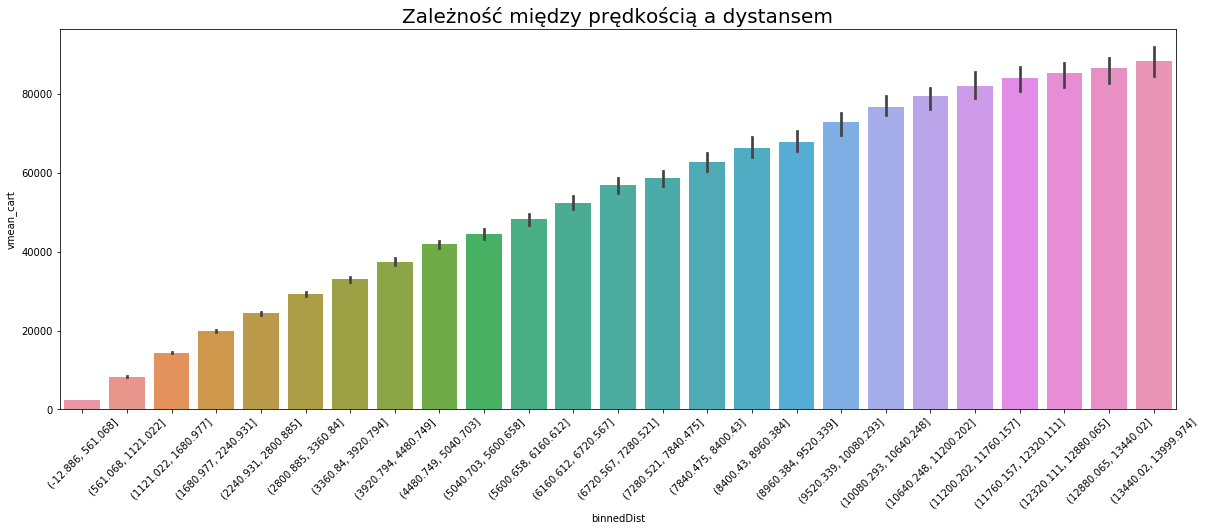

In [25]:
databinned1 = data[['distance_cart','vmean_cart']]
databinned1 = databinned1[(databinned1.distance_cart<14000) & (databinned1.vmean_cart!=means.values[0][0]) & (databinned1.distance_cart>0)]
databinned1['binnedDist'] = pd.cut(databinned1.distance_cart,bins=25)

fig, axarr = plt.subplots(figsize=(20,7))
# matplotlib.axes.Axes.set_yticks(ticks=[1,2,3,4], minor=False)
plt.xticks(rotation=45)

plt.title('Zależność między prędkością a dystansem',fontsize=20)
sns.barplot(data=databinned1,x='binnedDist', y='vmean_cart',estimator=np.median)
# .set_yticks(ticks=range(100000,1000000,100000), minor=True)

means1 = databinned1[['binnedDist','vmean_cart']].groupby('binnedDist').median()
means1['SampleSize'] = None
for i in range(len(means1.index)):
    means1['SampleSize'][i] = len(databinned1[databinned1.binnedDist==means1.index[i]])

means1

Podobnie jak na wcześniejszym wykresie chcieliśmy uwidoczynić tendencję wzrostową przy jednoczesnym podziale dystansu na jak największą liczbę przedziałów. Wraz ze wzrostwem liczby przedziałów rśnie precyzja doboru prawidłowej wartości do imputacji.

In [26]:
for i in range(len(means1)):
    data.vmean_cart[(data.distance_cart<=means1.index[i].right) & (data.distance_cart>means1.index[i].left)  & (data.distance_cart>0) & (data.vmean_cartLOG==np.Inf)] = means1.vmean_cart.iloc[i]

data.traj_time = data.distance_cart / data.vmean_cart

data['vmean_cartLOG'] = data.vmean_cart.map(lambda x: np.log(x))

timedelta = pd.to_timedelta(data.traj_time,unit='h').map(lambda x: x.total_seconds()/3600)
data.time_entry = [data.time_entry[i] - datetime.timedelta(hours=timedelta[i]) if (data.distance_cart[i]>0) & (data.vmean_cartLOG[i]==np.Inf) else data.time_entry[i] for i in range(len(data))] 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Jako że zostało jeszcze około 2000 przypadków w których przy zmiennej vmean_cartLOG są wartości -inf (oraz jednocześnie zera przy vmean_cart). Jako że wartości te stanowią duży problem dla normalności rozkładu zdecydowaliśmy się podjąć następujące kroki:

* Obserwacje ze zbioru testowego nie zostaną usunięte
* Obserwacje ze zbioru treningowego będą usunięte jedynie, gdy liczba obserwacji z wartościami -Inf jest jest o co najmniej dwa mniejsza od ogólnej liczby obserwacji dla danego hasha. W przeciwnym wypadku cały hash zostanie usunięty.

Warto również podkreślić, że obserwacje które pozostały nie wnoszą dodatkowej informacji o położeniu hasha. Ich lokalizacja jest dokładnie taka sama co lokalizacja w poprzedniej lub następnej trajektorii.

Powiedzmy ze tych nie usuwamy w ogóle:

In [27]:
data[data.vmean_cartLOG==-np.Inf]

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,x_entry,y_entry,x_exit,y_exit,train,distance_cart,time_entry_seconds,time_exit_seconds,traj_time,vmean_cart,DistanceFromCCentry,IsInCCentry,DistanceFromCC,IsInCC,hashSHIFT-1,closetoCC,TimeTillDeadline,Hour,vmean_cartLOG,hashSHIFT1,y_exitSHIFT1,x_exitSHIFT1,y_entrySHIFT-1,x_entrySHIFT-1,MoveBetweenTraj1,MoveBetweenTraj-1,target
432,432,0029e571241a3380b0e814260dc117e5_31,traj_0029e571241a3380b0e814260dc117e5_31_0,03:57:28,03:57:28,3.757110e+06,-1.924961e+07,3.757110e+06,-1.924961e+07,1,0.0,14248.0,14248.0,NaN,0.0,0.000000,1,0.000000,1,0029e571241a3380b0e814260dc117e5_31,0,11.042222,3,-inf,0029d917352b7668953513cfc3b4478f_19,-1.910090e+07,3.761044e+06,-1.924961e+07,3.757110e+06,0.0,0.0,0
959,959,0057c298d84c985ace026ca44b8f7e0a_19,traj_0057c298d84c985ace026ca44b8f7e0a_19_1,11:14:19,11:14:19,3.758756e+06,-1.923443e+07,3.758756e+06,-1.923443e+07,1,0.0,40459.0,40459.0,NaN,0.0,0.000000,1,0.000000,1,0057c298d84c985ace026ca44b8f7e0a_19,0,3.761389,11,-inf,00574fb9f039bbbdcb383f532082a0c6_9,-1.926214e+07,3.760965e+06,-1.923443e+07,3.758756e+06,0.0,0.0,0
960,960,0057c298d84c985ace026ca44b8f7e0a_19,traj_0057c298d84c985ace026ca44b8f7e0a_19_4,15:14:19,15:14:19,3.758756e+06,-1.923443e+07,3.758756e+06,-1.923443e+07,1,0.0,54859.0,54859.0,NaN,0.0,0.000000,1,0.000000,1,0057d4cf7891eb6b6dc1e410f8990668_31,0,0.000000,15,-inf,0057c298d84c985ace026ca44b8f7e0a_19,-1.923443e+07,3.758756e+06,-1.936025e+07,3.747070e+06,0.0,0.0,0
1125,1125,00621f8c40022067f8dd6b059db0b678_31,traj_00621f8c40022067f8dd6b059db0b678_31_3,15:14:07,15:14:07,3.745901e+06,-1.920040e+07,3.745901e+06,-1.920040e+07,1,0.0,54847.0,54847.0,NaN,0.0,5000.641606,0,5000.641606,0,00628f4cc342d93a06a03a055cb8f562_25,0,0.000000,15,-inf,00621f8c40022067f8dd6b059db0b678_31,-1.920040e+07,3.745901e+06,-1.915465e+07,3.772294e+06,0.0,0.0,0
1210,1210,006818714f6c2faaf187f8875cd511db_25,traj_006818714f6c2faaf187f8875cd511db_25_9,15:44:15,15:44:15,3.750184e+06,-1.910426e+07,3.750184e+06,-1.910426e+07,1,0.0,56655.0,56655.0,NaN,0.0,717.067601,0,717.067601,0,00688f4e239f4da595817f71398fc0fc_5,0,0.000000,15,-inf,006818714f6c2faaf187f8875cd511db_25,-1.910426e+07,3.750184e+06,-1.917852e+07,3.763270e+06,0.0,0.0,0
1401,1401,0076306da8dc94c83a63e2bf839bffcb_29,traj_0076306da8dc94c83a63e2bf839bffcb_29_0,03:57:13,03:57:13,3.755745e+06,-1.910420e+07,3.755745e+06,-1.910420e+07,1,0.0,14233.0,14233.0,NaN,0.0,4843.340965,0,4843.340965,0,0076306da8dc94c83a63e2bf839bffcb_29,0,11.046389,3,-inf,007614b379fe72bce6960c0e0413d4db_11,-1.923223e+07,3.759397e+06,-1.910420e+07,3.755745e+06,0.0,0.0,0
1402,1403,0076306da8dc94c83a63e2bf839bffcb_29,traj_0076306da8dc94c83a63e2bf839bffcb_29_4,15:09:15,15:09:15,3.755745e+06,-1.910420e+07,3.755745e+06,-1.910420e+07,1,0.0,54555.0,54555.0,NaN,0.0,4843.340965,0,4843.340965,0,0076a04e897e6156c46436251480c039_19,0,0.000000,15,-inf,0076306da8dc94c83a63e2bf839bffcb_29,-1.910420e+07,3.755745e+06,-1.923783e+07,3.756935e+06,0.0,0.0,0
1953,1958,00a5df93dd22cd815eff9d0345a6083f_19,traj_00a5df93dd22cd815eff9d0345a6083f_19_17,15:16:51,15:16:51,3.744779e+06,-1.926889e+07,3.744779e+06,-1.926889e+07,1,0.0,55011.0,55011.0,NaN,0.0,17.575529,0,17.575529,0,00a65b0fab2cc231ea68361489b41bb7_5,0,0.000000,15,-inf,00a5df93dd22cd815eff9d0345a6083f_19,-1.926889e+07,3.744779e+06,-1.935763e+07,3.758759e+06,0.0,0.0,0
2878,2883,00f855467f62135e5c8f796f6d0254cf_15,traj_00f855467f62135e5c8f796f6d0254cf_15_0,15:22:38,15:22:38,3.744994e+06,-1.928538e+07,3.744994e+06,-1.928538e+07,1,0.0,55358.0,55358.0,NaN,0.0,5907.895456,0,5907.895456,0,00f86163c6477a58b544b94f5d7fcc82_1,0,0.000000,15,-inf,00f83f9ef1e00f3a365950f2814254cc_15,-1.920485e+07,3.767840e+06,-1.935602e+07,3.757511e+06,0.0,0.0,0
4780,4785,0187a271d6d2454002e1da81064768a3_11,traj_0187a271d6d2454002e1da81064768a3_11_0,15:22:24,15:22:24,3.744770e+06,-1.928902e+07,3.744770e+06,-1.928902e+07,1,0.0,55344.0,55344.0,NaN,0.0,6131.647633,0,6131.647633,0,0187da182e332b7eec9ae6aebe876311_11,0,0.000000,15,-inf,0187633dda21

In [28]:
# data = data.drop(list(data[data.vmean_cartLOG==-np.Inf].loc[814011:].index),axis=0)

# problems = []
# for i in data[data.vmean_cartLOG==-np.Inf]['hash'].unique():
#     Infs1 = data.vmean_cartLOG[(data.hash==i)] == -np.Inf
#     Infs = list(Infs1[Infs1].index)
#     if len(data.vmean_cartLOG[data.hash==i]) >= sum(Infs1) + 2:
#         problems = problems + Infs
#     else:
#         problems = problems + list(data.vmean_cart[data.hash==i].index)
        
# data = data.drop(problems,axis=0)

Dodatkowo utworzona zostanie zmienna 'TimeSpentInExitPoint' która będzie stanowić informację o tym jak długo dane urządzenie spędziło w danej lokalizacji (ile czasu minęło od zakończenia trajektorii n do rozpoczęcia trajektorii n+1)

In [29]:
data['time_entry_secondsSHIFT-1'] = data.time_entry_seconds.shift(-1)
data['hashSHIFT-1'] = data.hash.shift(-1)
data['TimeSpentInExitPoint'] = None
data['TimeSpentInExitPoint'] = np.where((data.hash==data['hashSHIFT-1']),(data['time_entry_secondsSHIFT-1'] - data.time_exit_seconds) / 3600, ((16 * 3600) - data.time_exit_seconds)/3600)

Ostatnimi imputacjami będzie dodanie distance_cart oraz vmean_cart w miejsca w obserwacjach do zaobserwowania. Średnia prędkość trajektorii będzie imputowana w oparciu o zależność między średnią prędkością na trajektorii a czasem trwania trajektorii (zakładamy, że im dłużej trwa dana trajektoria tym do pewnego momentu szybciej będzie się poruszała dana osoba), a w opaciu o imputowaną trajektorię dodany zostanie przebyty dystans.

In [30]:
data['traj_time'] = data['time_exit_seconds'] - data['time_entry_seconds']
data['traj_time'] = data['traj_time']/3600

In [31]:
data.traj_time[data.distance_cart.isnull() & (data.traj_time>0)].describe(percentiles=[.01,.99])

count    16674.000000
mean         0.231029
std          0.220004
min          0.000278
1%           0.008333
50%          0.165278
99%          1.016328
max          3.924167
Name: traj_time, dtype: float64

Jak można zauważyć na powyższych danych, 99% wartoci traj_time nie przekracza godziny czasu. W związku z tym zrobimy osobne kategorie czasu vs dystansu trajektorii dla tych poniżej godziny, a pozostałe obserwacje będą miały przypisaną prędkość na podstawie pozostałych kategorii

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,vmean_cart,SampleSize
binnedTraj,,
"(-0.00102, 0.068]",31820.637092,612495
"(0.068, 0.136]",30535.962450,128187
"(0.136, 0.204]",52939.815308,80467
"(0.204, 0.272]",88634.756430,46948
"(0.272, 0.34]",97837.867420,34223
"(0.34, 0.408]",105535.655471,22725
"(0.408, 0.476]",108091.869148,17074
"(0.476, 0.544]",100919.175121,11877
"(0.544, 0.612]",95511.906482,7915


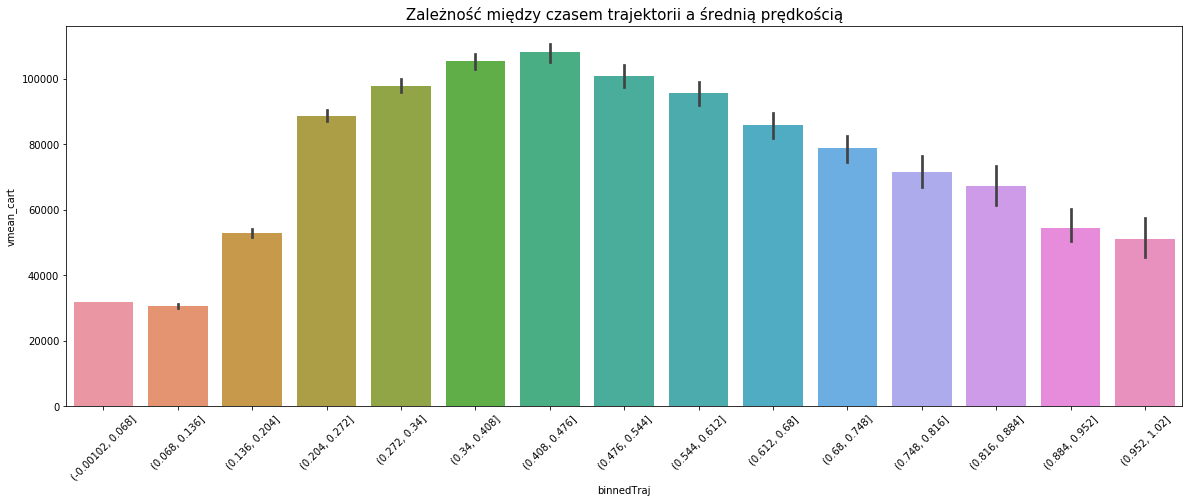

In [32]:
databinned1 = data[['traj_time','vmean_cart','Hour']]
databinned1 = databinned1[(databinned1.vmean_cart>0) & (data.traj_time<=1.02)]
databinned1['binnedTraj'] = pd.cut(databinned1.traj_time,bins=15)

fig, axarr = plt.subplots(figsize=(20,7))
# matplotlib.axes.Axes.set_yticks(ticks=[1,2,3,4], minor=False)
plt.xticks(rotation=45)

plt.title('Zależność między czasem trajektorii a średnią prędkością',fontsize=15)
sns.barplot(data=databinned1,x='binnedTraj', y='vmean_cart',estimator=np.median)
# .set_yticks(ticks=range(100000,1000000,100000), minor=True)

means2 = databinned1[['binnedTraj','vmean_cart']].groupby('binnedTraj').median()
means2['SampleSize'] = None
for i in range(len(means2.index)):
    means2['SampleSize'][i] = len(databinned1[databinned1.binnedTraj==means2.index[i]])

means2

In [33]:
for i in range(len(means2)):
    data.vmean_cart[(data.traj_time<=means2.index[i].right) & (data.traj_time>means2.index[i].left)  & (data.vmean_cart.isnull())] = means2.vmean_cart.iloc[i]

data.time_entry_seconds = data.time_entry.map(lambda x: x.seconds)
data.traj_time = (data.time_exit_seconds - data.time_entry_seconds)/3600
data.distance_cart =  data.traj_time * data.vmean_cart

data['vmean_cartLOG'] = data.vmean_cart.map(lambda x: np.log(x))

# timedelta = pd.to_timedelta(data.traj_time,unit='h').map(lambda x: x.total_seconds()/3600)
# data.time_entry = [data.time_entry[i] - datetime.timedelta(hours=timedelta[i]) if (data.distance_cart[i]>0) & (data.vmean_cartLOG[i]==np.Inf) else data.time_entry[i] for i in range(len(data))] 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,vmean_cart,SampleSize
binnedTraj,,
"(1.014, 1.988]",31820.637092,13024
"(1.988, 2.956]",18976.581706,225
"(2.956, 3.924]",12465.471788,50
"(3.924, 4.891]",22961.595268,14
"(4.891, 5.859]",10386.178503,5
"(5.859, 6.827]",643.227002,1


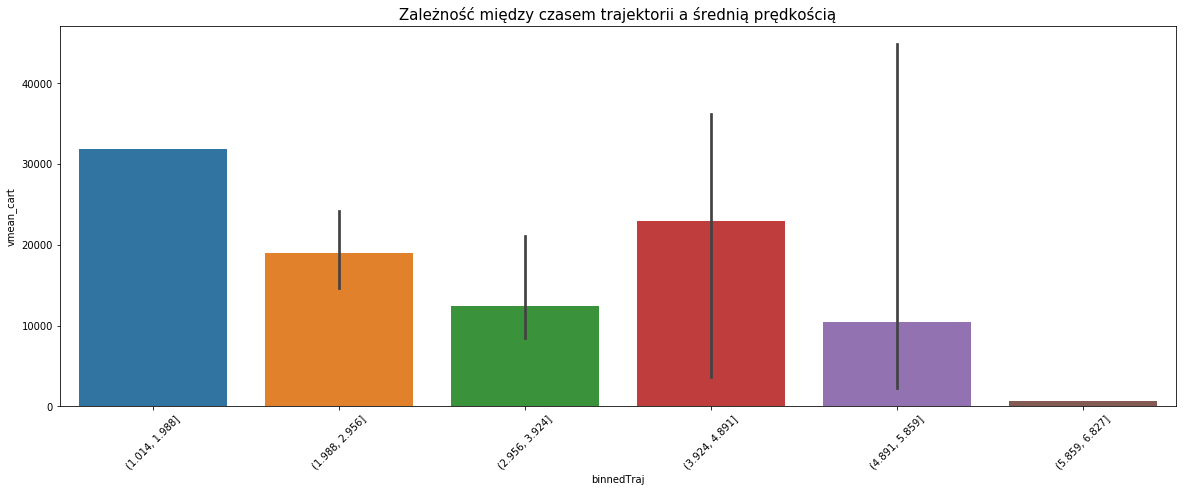

In [34]:
databinned1 = data[['traj_time','vmean_cart','Hour']]
databinned1 = databinned1[(databinned1.vmean_cart>0) & (data.traj_time>1.02)]
databinned1['binnedTraj'] = pd.cut(databinned1.traj_time,bins=6)

fig, axarr = plt.subplots(figsize=(20,7))
# matplotlib.axes.Axes.set_yticks(ticks=[1,2,3,4], minor=False)
plt.xticks(rotation=45)

plt.title('Zależność między czasem trajektorii a średnią prędkością',fontsize=15)
sns.barplot(data=databinned1,x='binnedTraj', y='vmean_cart',estimator=np.median)
# .set_yticks(ticks=range(100000,1000000,100000), minor=True)

means3 = databinned1[['binnedTraj','vmean_cart']].groupby('binnedTraj').median()
means3['SampleSize'] = None
for i in range(len(means3.index)):
    means3['SampleSize'][i] = len(databinned1[databinned1.binnedTraj==means3.index[i]])

means3

In [35]:
for i in range(len(means3)):
    data.vmean_cart[(data.traj_time<=means3.index[i].right) & (data.traj_time>means3.index[i].left)  & (data.vmean_cart.isnull())] = means3.vmean_cart.iloc[i]

data.time_entry_seconds = data.time_entry.map(lambda x: x.seconds)
data.traj_time = (data.time_exit_seconds - data.time_entry_seconds)/3600
data.distance_cart =  data.traj_time * data.vmean_cart

data['vmean_cartLOG'] = data.vmean_cart.map(lambda x: np.log(x))

# timedelta = pd.to_timedelta(data.traj_time,unit='h').map(lambda x: x.total_seconds()/3600)
# data.time_entry = [data.time_entry[i] - datetime.timedelta(hours=timedelta[i]) if (data.distance_cart[i]>0) & (data.vmean_cartLOG[i]==np.Inf) else data.time_entry[i] for i in range(len(data))] 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [36]:
data[(data.traj_time==0) & (data.vmean_cart>0)]

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,x_entry,y_entry,x_exit,y_exit,train,distance_cart,time_entry_seconds,time_exit_seconds,traj_time,vmean_cart,DistanceFromCCentry,IsInCCentry,DistanceFromCC,IsInCC,hashSHIFT-1,closetoCC,TimeTillDeadline,Hour,vmean_cartLOG,hashSHIFT1,y_exitSHIFT1,x_exitSHIFT1,y_entrySHIFT-1,x_entrySHIFT-1,MoveBetweenTraj1,MoveBetweenTraj-1,target,time_entry_secondsSHIFT-1,TimeSpentInExitPoint
8646,8651,02b13a4497b8c1ae9e2dfe6ffe22e564_31,traj_02b13a4497b8c1ae9e2dfe6ffe22e564_31_2,10:13:35,10:13:35,3.776593e+06,-1.916947e+07,3.776584e+06,-1.916929e+07,1,0.0,36815,36815.0,0.0,2393.087392,5691.255200,0,5682.349641,0,02b13a4497b8c1ae9e2dfe6ffe22e564_31,1,4.773611,10,7.780340,02b13a4497b8c1ae9e2dfe6ffe22e564_31,-1.916955e+07,3.776025e+06,-1.917319e+07,3.776623e+06,0.0,0.0,0,38221.0,0.390556
19989,19997,064adf11a010dcc0734ac3dcee20a9d6_1,traj_064adf11a010dcc0734ac3dcee20a9d6_1_8,12:22:03,12:22:03,3.767824e+06,-1.920685e+07,3.767829e+06,-1.920675e+07,1,0.0,44523,44523.0,0.0,2393.087392,2056.718365,0,2158.729399,0,064adf11a010dcc0734ac3dcee20a9d6_1,0,2.632500,12,7.780340,064adf11a010dcc0734ac3dcee20a9d6_1,-1.920497e+07,3.767836e+06,-1.920848e+07,3.767734e+06,0.0,0.0,0,47822.0,0.916389
25829,25837,081a398f286d9c7eb0097c4ddd41d553_29,traj_081a398f286d9c7eb0097c4ddd41d553_29_23,11:04:03,11:04:03,3.771995e+06,-1.931883e+07,3.772002e+06,-1.931890e+07,1,0.0,39843,39843.0,0.0,2393.087392,1093.760231,0,1100.439400,0,081a398f286d9c7eb0097c4ddd41d553_29,0,3.932500,11,7.780340,081a398f286d9c7eb0097c4ddd41d553_29,-1.931835e+07,3.772081e+06,-1.932919e+07,3.766475e+06,0.0,0.0,0,43874.0,1.119722
28412,28420,08d3c5af1a15e914a1cad358b7a58902_15,traj_08d3c5af1a15e914a1cad358b7a58902_15_5,10:45:09,10:45:09,3.746278e+06,-1.935705e+07,3.746254e+06,-1.935686e+07,1,0.0,38709,38709.0,0.0,2393.087392,4623.268533,0,4647.758821,0,08d3c5af1a15e914a1cad358b7a58902_15,0,4.247500,10,7.780340,08d3c5af1a15e914a1cad358b7a58902_15,-1.935703e+07,3.746302e+06,-1.926845e+07,3.755999e+06,0.0,0.0,0,47490.0,2.439167
41828,41841,0d04a5d9f33926823c9760066730cbe9_31,traj_0d04a5d9f33926823c9760066730cbe9_31_3,14:44:33,14:44:33,3.752328e+06,-1.928389e+07,3.752315e+06,-1.928408e+07,1,0.0,53073,53073.0,0.0,2393.087392,1426.945792,0,1413.587453,0,0d04a5d9f33926823c9760066730cbe9_31,1,0.257500,14,7.780340,0d04a5d9f33926823c9760066730cbe9_31,-1.928134e+07,3.751605e+06,-1.914075e+07,3.753139e+06,0.0,0.0,0,53973.0,0.250000
45349,45363,0e14beedbad7338c8ca6d95315f6b60e_31,traj_0e14beedbad7338c8ca6d95315f6b60e_31_5,11:09:32,11:09:32,3.757857e+06,-1.926401e+07,3.757845e+06,-1.926387e+07,1,0.0,40172,40172.0,0.0,2393.087392,0.000000,1,0.000000,1,0e14beedbad7338c8ca6d95315f6b60e_31,0,3.841111,11,7.780340,0e14beedbad7338c8ca6d95315f6b60e_31,-1.926457e+07,3.757763e+06,-1.926488e+07,3.757879e+06,0.0,0.0,0,47406.0,2.009444
63037,63060,13a5a774d487f2084925dfbf06b2a38a_19,traj_13a5a774d487f2084925dfbf06b2a38a_19_31,15:11:12,15:11:12,3.757773e+06,-1.926994e+07,3.757772e+06,-1.926998e+07,1,0.0,54672,54672.0,0.0,2393.087392,1035.442226,0,1069.782675,0,13a5c9ac8a6c51b1c54924cc5da8cbb0_31,0,0.000000,15,7.780340,13a5a774d487f2084925dfbf06b2a38a_19,-1.926471e+07,3.757752e+06,-1.920023e+07,3.776291e+06,0.0,0.0,0,23677.0,0.813333
66402,66425,14b833d80fe855e946a3ccd93550ac66_15,traj_14b833d80fe855e946a3ccd93550ac66_15_1,13:46:05,13:46:05,3.742884e+06,-1.931958e+07,3.742874e+06,-1.931991e+07,1,0.0,49565,49565.0,0.0,2393.087392,8017.399807,0,8027.418561,0,14b833d80fe855e946a3ccd93550ac66_15,0,1.231944,13,7.780340,14b7b6cbe9b0f684663fba9342dff6fd_9,-1.916023e+07,3.761596e+06,-1.931743e+07,3.742877e+06,0.0,0.0,0,51309.0,0.484444
76298,76327,17c116305445e7d8bc6f5c54028c99e1_9,traj_17c116305445e7d8bc6f5c54028c99e1_9_8,10:00:18,10:00:18,3.744661e+06,-1.928762e+07,3.744675e+06,-1.928740e+07,1,0.0,36018,36018.0,0.0,2393.087392,6240.740734,0,6226.269200,0,17c116305445e7d8bc6f5c54028c99e1_9,1,4.995000,10,7.780340,17c116305445e7d8bc6f5c54028c99e1_9,-1.928587e+07,3.744686e+06,-1.928669e+07,

Na chwilę obecną wszystkie braki danych które można było uzupełnić zostały uzupełnione. W celu stworzenia pliku do dalszych analiz dodamy zmienną dataset.

Ze względu na sekwencyjny charakter danych należy pogrupować trajektorie według godzin. Problem jednak pojawia się, gdy w ciągu jednej godziny mamy więcej niż jedną trajektorię (np. między godziną 15 a 16 jest trajektoria trwająca od 15:01 do 15:04 i od 15:22 do 15:44). W takich wypadach będziemy uwzględniać jedynie ostatnią z trajektorii przyjmujący tym samym ciche założenie, że jej wpływ jest najistotniejszy.

Ponadto grupy godzinowe będą od godziny 5 do godziny 15. Godziny od 0 do 4 nie będą uwzględniane ze względu na podejrzenie znikomego wpływu lokalizacji o tyh godzinach.

W celu pogrupowania tych zmiennych utworzony zostanie nowy dataframe o nazwie "lol" który początkowo będzie pusty, jednak później zostaną do niego dodane wartości ze zmiennej dataset.

In [37]:
chash = data.hash[data.vmean_cart>100000000]
for ch in chash: 
    c= data[data.hash==ch].index
    data.drop(c, inplace=True)
chash = data.hash[(data.vmean_cart>80000000)]
for ch in chash: 
    c= data[data.hash==ch].index
    data.drop(c, inplace=True) 
chash = data[(data.vmean_cart>40000000) & (data.TimeSpentInExitPoint>5)]
for ch in chash: 
    c= data[data.hash==ch].index
    data.drop(c, inplace=True)
chash = data.hash[(data.traj_time>6)]
for ch in chash: 
    c= data[data.hash==ch].index
    data.drop(c, inplace=True) 
# data = data.drop(['hash'],axis=1)  

In [38]:
data

,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,x_entry,y_entry,x_exit,y_exit,train,distance_cart,time_entry_seconds,time_exit_seconds,traj_time,vmean_cart,DistanceFromCCentry,IsInCCentry,DistanceFromCC,IsInCC,hashSHIFT-1,closetoCC,TimeTillDeadline,Hour,vmean_cartLOG,hashSHIFT1,y_exitSHIFT1,x_exitSHIFT1,y_entrySHIFT-1,x_entrySHIFT-1,MoveBetweenTraj1,MoveBetweenTraj-1,target,time_entry_secondsSHIFT-1,TimeSpentInExitPoint
0,0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,1,42364.863118,25471,25712.0,0.066944,632836.129557,112.262606,0,575.691847,0,0000a8602cf2def930488dee7cdad104_1,0,7.857778,7,13.357967,NaN,NaN,NaN,-1.932247e+07,3.743937e+06,0.000000,0.000000,0,26434.0,0.200556
1,1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,1,2989.643628,26434,26742.0,0.085556,34943.886561,6964.317424,0,5926.819770,0,0000a8602cf2def930488dee7cdad104_1,1,7.571667,7,10.461499,0000a8602cf2def930488dee7cdad104_1,-1.913634e+07,3.750326e+06,-1.929356e+07,3.744868e+06,0.000000,0.000000,0,28412.0,0.463889
2,2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,1,725.658561,28412,29005.0,0.164722,4405.347082,6033.686481,0,6086.006642,0,0000a8602cf2def930488dee7cdad104_1,0,6.943056,8,8.390574,0000a8602cf2def930488dee7cdad104_1,-1.931966e+07,3.744975e+06,-1.929229e+07,3.744880e+06,0.000000,0.000000,0,29870.0,0.240278
3,3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,1,1804.576849,29870,31043.0,0.325833,5538.343270,6021.441337,0,6092.685811,0,0000a8602cf2def930488dee7cdad104_1,0,6.376944,8,8.619451,0000a8602cf2def930488dee7cdad104_1,-1.929284e+07,3.744816e+06,-1.928558e+07,3.744909e+06,0.000000,0.000000,0,52689.0,6.012778
4,4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:31:04.597850,14:38:09,3.744809e+06,-1.929049e+07,3.744945e+06,-1.928183e+07,1,3756.602990,52264,52689.0,0.118056,31820.637092,5992.498269,0,5992.498269,0,0000a8602cf2def930488dee7cdad104_1,0,0.364167,14,10.367870,0000a8602cf2def930488dee7cdad104_1,-1.929049e+07,3.744809e+06,-1.928183e+07,3.744945e+06,4902.621682,3751.318555,0,54151.0,0.406111
5,5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,3.744945e+06,-1.928183e+07,3.744785e+06,-1.928148e+07,1,389.513093,54151,55113.0,0.267222,1457.637355,5956.876032,0,6116.062904,0,0000cf177130469eeac79f67b6bcf3df_9,0,0.000000,15,7.284572,0000a8602cf2def930488dee7cdad104_1,-1.928558e+07,3.744909e+06,-1.926506e+07,3.749450e+06,0.000000,0.000000,0,52163.0,0.690833
6,6,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_0,14:25:09.917592,14:29:23,3.749450e+06,-1.926506e+07,3.749090e+06,-1.926726e+07,1,2245.122728,51909,52163.0,0.070556,31820.637092,1451.776240,0,1451.776240,0,0000cf177130469eeac79f67b6bcf3df_9,0,0.510278,14,10.367870,0000a8602cf2def930488dee7cdad104_1,-1.928148e+07,3.744785e+06,-1.926726e+07,3.749090e+06,0.000000,2237.012077,0,52789.0,0.173889
7,7,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_1,14:38:02.722262,14:39:49,3.749450e+06,-1.926506e+07,3.749042e+06,-1.926632e+07,1,945.780047,52682,52789.0,0.029722,31820.637092,1642.545984,0,1642.545984,0,0000cf177130469eeac79f67b6bcf3df_9,0,0.336389,14,10.367870,0000cf177130469eeac79f67b6bcf3df_9,-1.926506e+07,3.749450e+06,-1.926632e+07,3.749042e+06,2237.012077,939.395933,0,53414.0,0.173611
8,8,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_2,14:49:42.511419,14:50:14,3.749090e+06,-1.926726e+07,3.749088e+06,-1.926605e+07,1,282.850107,53382,53414.0,0.008889,31820.637092,1859.205576,0,1859.205576,0,0000cf177130469eeac79f67b6bcf3df_9,

In [39]:
data = data.drop(data[(data.Hour>=0) & (data.Hour<5)].index,axis=0)

dataset = data[['Hour','hash','trajectory_id','DistanceFromCCentry','DistanceFromCC','vmean_cart','IsInCCentry','IsInCC','TimeSpentInExitPoint','traj_time','distance_cart']].groupby(['hash','Hour']).agg(
    {'DistanceFromCCentry': 'last',
    'vmean_cart':'last',
    'IsInCCentry':'last',
    'IsInCC':'last',
    'TimeSpentInExitPoint':'last',
    'DistanceFromCC':'last',
    'traj_time':'last',
    'trajectory_id':'last',
    'distance_cart':'last'})

In [40]:

dataset1 = dataset.reset_index()
lol = pd.DataFrame({'hash':np.repeat(dataset1.hash.unique(),11),'Hour':range(11*len(dataset1.hash.unique())),'trajectory_id':np.nan,'DistanceFromCCentry':np.nan,'vmean_cart':np.nan,'IsInCCentry':np.nan,'IsInCC':np.nan,'TimeSpentInExitPoint':1,'traj_time':np.nan,'distance_cart':np.nan}, index=range(11*len(dataset1.hash.unique())),\
             columns=['trajectory_id','Hour','hash','DistanceFromCCentry','DistanceFromCC','vmean_cart','IsInCCentry','IsInCC','TimeSpentInExitPoint','traj_time','distance_cart'])

lol.Hour = lol.Hour.map(lambda x: (x%11)+5)
lol = lol[['Hour','trajectory_id','hash','DistanceFromCCentry','DistanceFromCC','vmean_cart','IsInCCentry','IsInCC','TimeSpentInExitPoint','traj_time','distance_cart']].groupby(['hash','Hour']).agg(
    {'DistanceFromCCentry': 'last',
    'vmean_cart':'last',
    'IsInCCentry':'last',
    'IsInCC':'last',
    'TimeSpentInExitPoint':'last',
    'DistanceFromCC':'last',
    'traj_time':'last',
    'trajectory_id': 'last',
    'distance_cart':'last'})

# lol.loc[dataset.index] = dataset
lol.update(dataset)
    


Kolejnym krokiem będzie imputacja danych dla godzin, które nie wystepowały w pierwotnym dataframie. W miejsce pustych wartości komórek zmiennej *DistanceFromCCentry* które poprzedzają pierwszą prawdziwą trajektorię dla danego hasha imputujemy wartość *DistanceFromCCentry* z pierwszej prawdziwej trajektorii.

Jeżeli chodzi o kolejne brakujące wartości w *DistanceFromCCentry* to wstawione będą wartości *DistanceFromCC*.



In [41]:
xd = data[['Hour','trajectory_id','hash','DistanceFromCCentry','DistanceFromCC','vmean_cart','IsInCCentry','IsInCC','TimeSpentInExitPoint','distance_cart']].groupby(['hash','Hour']).agg(
    {'DistanceFromCCentry':'last',
     'DistanceFromCC':'last',
     'trajectory_id':'last',
    'distance_cart':'last'}).reset_index()

xd = xd[['Hour','trajectory_id','hash','DistanceFromCCentry','DistanceFromCC','distance_cart']].groupby(['hash']).agg(
    {'Hour':'first',
     'DistanceFromCCentry':'first',
     'DistanceFromCC':'first',
    'distance_cart':'first'}).reset_index()

xd = xd[['Hour','hash','DistanceFromCCentry','DistanceFromCC','distance_cart']].groupby(['hash','Hour']).agg(
{'DistanceFromCC':'last',
'DistanceFromCCentry':'last',
'distance_cart':'last'})

xd

# xd['DistanceFromCCentry'] = lol['DistanceFromCCentry']
# lol = lol.drop(16,axis=1)

lol['Minimal'] = np.repeat(xd.reset_index().groupby(['hash']).agg({'Hour':'last'}).values,11)

lol = lol.reset_index()

lol['DistanceFromCCentry'] = np.where(lol.Hour<lol.Minimal,np.repeat(xd.DistanceFromCCentry.values,11),lol.DistanceFromCCentry)
lol['distance_cart'] = np.where(lol.Hour<lol.Minimal,np.repeat(xd.distance_cart.values,11),lol.distance_cart)
# lol['IsInCC'] = np.where(lol.Hour<lol.Minimal,lol.IsInCCSHIFT1,lol.IsInCC)
# lol['traj_time'] = np.where(lol.Hour<lol.Minimal,lol.traj_timeSHIFT1,lol.traj_time)






# lol = lol.copy()

for g in range(10):
    lol['DistanceFromCCSHIFT1'] = lol.DistanceFromCC.shift(1) 
    lol['traj_timeSHIFT1'] = lol.traj_time.shift(1) 
    lol['distance_cartSHIFT1'] = lol.distance_cart.shift(1) 


    lol['distance_cart'] = np.where((lol.DistanceFromCCentry.isnull()) & (lol.DistanceFromCC.isnull()),lol.distance_cartSHIFT1,lol.distance_cart)
    lol['DistanceFromCCentry'] = np.where((lol.DistanceFromCCentry.isnull()) & (lol.DistanceFromCC.isnull()),lol.DistanceFromCCSHIFT1,lol.DistanceFromCCentry)
    lol['traj_time'] = np.where((lol.DistanceFromCCentry.isnull()) & (lol.DistanceFromCC.isnull()),lol.traj_timeSHIFT1,lol.traj_time)


    lol.distance_cart[(lol.distance_cart.isnull()) & (lol.TimeSpentInExitPoint==1)] = lol.distance_cart
    lol.DistanceFromCC[(lol.DistanceFromCC.isnull()) & (lol.TimeSpentInExitPoint==1)] = lol.DistanceFromCCentry
    lol.traj_time[(lol.traj_time.isnull()) & (lol.TimeSpentInExitPoint==1)] = lol.traj_time



#     lol['DistanceFromCCentrySHIFT-1'] = lol.DistanceFromCCentry.shift(-1) 
#     lol['IsInCCentrySHIFT-1'] = lol.IsInCCentry.shift(-1
#     lol['IsInCCSHIFT-1'] = lol.IsInCC.shift(-1) 
#     lol['traj_timeSHIFT-1'] = lol.traj_time.shift(-1) 


#     lol['DistanceFromCCentry'] = np.where((lol.DistanceFromCCentry.isnull()) & (lol.DistanceFromCC.isnull()),lol['DistanceFromCCentrySHIFT-1'],lol.DistanceFromCCentry)
#     lol['IsInCCentry'] = np.where((lol.IsInCCentry.isnull()) & (lol.IsInCCentry.isnull()),lol['IsInCCentrySHIFT-1'],lol.IsInCCentry)
#     lol['IsInCC'] = np.where((lol.IsInCC.isnull()) & (lol.IsInCC.isnull()),lol['IsInCCSHIFT-1'],lol.IsInCC)
#     lol['traj_time'] = np.where((lol.DistanceFromCCentry.isnull()) & (lol.DistanceFromCC.isnull()),lol['traj_timeSHIFT-1'],lol.traj_time)


#     lol.DistanceFromCC[(lol.DistanceFromCC.isnull()) & (lol.TimeSpentInExitPoint==1)] = lol.DistanceFromCCentry
#     lol.IsInCCentry[(lol.IsInCCentry.isnull()) & (lol.TimeSpentInExitPoint==1)] = lol.IsInCCentry
#     lol.IsInCC[(lol.IsInCC.isnull()) & (lol.TimeSpentInExitPoint==1)] = lol.IsInCC
#     lol.traj_time[(lol.traj_time.isnull()) & (lol.TimeSpentInExitPoint==1)] = lol.traj_time


lol = lol.fillna(0)

lol['IsInCCentry'] = np.where(lol.DistanceFromCCentry>0,0,1)
lol['IsInCC'] = np.where(lol.DistanceFromCC>0,0,1)

lol = lol.drop(['DistanceFromCCSHIFT1','Minimal','traj_timeSHIFT1','DistanceFromCC'],axis=1)
lol = lol.set_index('trajectory_id')
lol.IsInCC.loc[data.trajectory_id[(data.x_exit.isnull()) & (data.Hour==15)]] = np.nan

lol.vmean_cart[(lol.traj_time==0) & (lol.vmean_cart>0)] = 0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

Średnia dzienna prędkość i zmienna czy urządzenie jest w stanie dotrzeć do centrum przed danym punktem exit:


In [42]:
srednie = lol[['hash','vmean_cart']][lol.vmean_cart>0].groupby(['hash']).vmean_cart.mean()
zeroVhash = lol[['hash','vmean_cart']].groupby(['hash']).vmean_cart.sum()
zeroVhash = zeroVhash.reset_index()
zeroVhash = zeroVhash[zeroVhash.vmean_cart==0]
zeroVhash = zeroVhash.set_index('hash')

srednie.reset_index()
srednie = pd.DataFrame(srednie)

frames = [zeroVhash, srednie]
toimput = pd.concat(frames)

In [43]:
lol = lol.drop('distance_cartSHIFT1',axis=1)
lol = lol.copy()
for shift in range(1,11):
    lol['DistanceFromCCentrySHIFT{}'.format(shift)] = lol.DistanceFromCCentry.shift(shift)
    
#DODANIE DODATKOWEJ ZMIENNEJ OPÓŹNIONEJ:
# for shift in range(1,11):
#     lol['vmean_cart{}'.format(shift)] = lol.vmean_cart.shift(shift)
    
# for shift in range(1,11):
#     lol['traj_time{}'.format(shift)] = lol.traj_time.shift(shift)
  
# for shift in range(1,11):
#     lol['IsInCCentry{}'.format(shift)] = lol.IsInCCentry.shift(shift)
    
for shift in range(1,11):
    lol['IsInCC{}'.format(shift)] = lol.IsInCC.shift(shift)


    


lol = lol[(lol.Hour==15)]
lol = lol.drop(['Hour'],axis=1)


Do zmiennej Vallday zostaną dodane wartości średnich dziennych prędkości dla danego hasha; do prędkości nie są wliczane puste trajektorie (czyli te z zerową prędkością), a dla hashów, które przez cały dzień mają zerową prędkość - wrzucimy 0 jako wartość tej zmiennej.

Następnie zostanie policzony dystans, który dany punkt może pokonać w czasie traj_time i średniej dziennej prędkości, co posłuży nam do stworzenia zmiennej 'CanReachCC15', która będzie przyjmowała 1, gdy urządzenie może dotrzeć w lini prostej do centrum w ostatniej swojej trajektorii z punktu entry do punktu exit w zadanym czasie trajektorii. W przeciwnym wypadku zmienna przyjmie wartośc 0.

In [44]:
toimput = toimput.reset_index()
toimput = toimput.set_index('hash')
lol = lol.reset_index()
lol = lol.set_index('hash')

lol['Vallday'] = toimput.vmean_cart

lol['sofar'] = lol.Vallday * lol.traj_time
lol['rest'] = lol.sofar - lol.DistanceFromCCentry

lol['CanReachCC15'] = lol.rest.map(lambda x: 1 if x>=0 else 0)

lol[['DistanceFromCCentry','Vallday','sofar','rest','CanReachCC15']]

lol = lol.reset_index()
lol = lol.set_index('trajectory_id')
lol.head()
lol = lol.drop(['rest','sofar','Vallday'],axis=1)
lol.head()

,hash,DistanceFromCCentry,vmean_cart,IsInCCentry,IsInCC,TimeSpentInExitPoint,traj_time,distance_cart,DistanceFromCCentrySHIFT1,DistanceFromCCentrySHIFT2,DistanceFromCCentrySHIFT3,DistanceFromCCentrySHIFT4,DistanceFromCCentrySHIFT5,DistanceFromCCentrySHIFT6,DistanceFromCCentrySHIFT7,DistanceFromCCentrySHIFT8,DistanceFromCCentrySHIFT9,DistanceFromCCentrySHIFT10,IsInCC1,IsInCC2,IsInCC3,IsInCC4,IsInCC5,IsInCC6,IsInCC7,IsInCC8,IsInCC9,IsInCC10,CanReachCC15
trajectory_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
traj_0000a8602cf2def930488dee7cdad104_1_5,0000a8602cf2def930488dee7cdad104_1,5956.876032,1457.637355,0,0.0,0.690833,0.267222,389.513093,5992.498269,6092.685811,6092.685811,6092.685811,6092.685811,6092.685811,6021.441337,6964.317424,6964.317424,6964.317424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
traj_0000cf177130469eeac79f67b6bcf3df_9_3,0000cf177130469eeac79f67b6bcf3df_9,1813.564585,1095.733742,0,0.0,0.503333,0.487778,534.474570,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_0001f97b99a80f18f62e2d44e54ef33d_3_1,0001f97b99a80f18f62e2d44e54ef33d_3,7836.722072,309659.388000,0,0.0,0.669167,0.754444,233620.804947,6102.364405,6102.364405,6102.364405,559.426675,559.426675,559.426675,559.426675,559.426675,559.426675,559.426675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_0002124248b0ca510dea42824723ccac_31_10,0002124248b0ca510dea42824723ccac_31,3035.079683,31820.637092,0,0.0,0.518333,0.759167,24157.166992,0.000000,3037.306073,3038.419268,4563.496292,4563.496292,5357.204261,5357.204261,5357.204261,5357.204261,5357.204261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_000219c2a6380c307e8bffd85b5e404b_23_16,000219c2a6380c307e8bffd85b5e404b_23,3260.717965,215465.984579,0,0.0,0.865278,0.213333,45966.076710,1046.889022,1046.889022,1046.889022,3260.717965,3368.697871,3368.697871,3368.697871,3368.697871,3368.697871,3395.414549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [45]:
lol.head(5)

,hash,DistanceFromCCentry,vmean_cart,IsInCCentry,IsInCC,TimeSpentInExitPoint,traj_time,distance_cart,DistanceFromCCentrySHIFT1,DistanceFromCCentrySHIFT2,DistanceFromCCentrySHIFT3,DistanceFromCCentrySHIFT4,DistanceFromCCentrySHIFT5,DistanceFromCCentrySHIFT6,DistanceFromCCentrySHIFT7,DistanceFromCCentrySHIFT8,DistanceFromCCentrySHIFT9,DistanceFromCCentrySHIFT10,IsInCC1,IsInCC2,IsInCC3,IsInCC4,IsInCC5,IsInCC6,IsInCC7,IsInCC8,IsInCC9,IsInCC10,CanReachCC15
trajectory_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
traj_0000a8602cf2def930488dee7cdad104_1_5,0000a8602cf2def930488dee7cdad104_1,5956.876032,1457.637355,0,0.0,0.690833,0.267222,389.513093,5992.498269,6092.685811,6092.685811,6092.685811,6092.685811,6092.685811,6021.441337,6964.317424,6964.317424,6964.317424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
traj_0000cf177130469eeac79f67b6bcf3df_9_3,0000cf177130469eeac79f67b6bcf3df_9,1813.564585,1095.733742,0,0.0,0.503333,0.487778,534.474570,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_0001f97b99a80f18f62e2d44e54ef33d_3_1,0001f97b99a80f18f62e2d44e54ef33d_3,7836.722072,309659.388000,0,0.0,0.669167,0.754444,233620.804947,6102.364405,6102.364405,6102.364405,559.426675,559.426675,559.426675,559.426675,559.426675,559.426675,559.426675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_0002124248b0ca510dea42824723ccac_31_10,0002124248b0ca510dea42824723ccac_31,3035.079683,31820.637092,0,0.0,0.518333,0.759167,24157.166992,0.000000,3037.306073,3038.419268,4563.496292,4563.496292,5357.204261,5357.204261,5357.204261,5357.204261,5357.204261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_000219c2a6380c307e8bffd85b5e404b_23_16,000219c2a6380c307e8bffd85b5e404b_23,3260.717965,215465.984579,0,0.0,0.865278,0.213333,45966.076710,1046.889022,1046.889022,1046.889022,3260.717965,3368.697871,3368.697871,3368.697871,3368.697871,3368.697871,3395.414549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [46]:
lol.isnull().sum()

hash                              0
DistanceFromCCentry               0
vmean_cart                        0
IsInCCentry                       0
IsInCC                        33515
TimeSpentInExitPoint              0
traj_time                         0
distance_cart                     0
DistanceFromCCentrySHIFT1         0
DistanceFromCCentrySHIFT2         0
DistanceFromCCentrySHIFT3         0
DistanceFromCCentrySHIFT4         0
DistanceFromCCentrySHIFT5         0
DistanceFromCCentrySHIFT6         0
DistanceFromCCentrySHIFT7         0
DistanceFromCCentrySHIFT8         0
DistanceFromCCentrySHIFT9         0
DistanceFromCCentrySHIFT10        0
IsInCC1                           0
IsInCC2                           0
IsInCC3                           0
IsInCC4                           0
IsInCC5                           0
IsInCC6                           0
IsInCC7                           0
IsInCC8                           0
IsInCC9                           0
IsInCC10                    

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate

trainX, testX, trainY, testY = train_test_split(lol[lol.IsInCC.isnull()==False].drop('IsInCC',axis=1),lol.IsInCC[lol.IsInCC.isnull()==False],test_size=0.25, random_state=22)

# trainX = lol[lol.IsInCC.isnull()==False].drop('IsInCC',axis=1) 
# trainY = lol.IsInCC[lol.IsInCC.isnull()==False]
# testX = lol[lol.IsInCC.isnull()].drop('IsInCC',axis=1) 
# testY

# cv_results = cross_validate(XGBClassifier(), lol[lol.IsInCC.isnull()==False].drop('IsInCC',axis=1),lol.IsInCC[lol.IsInCC.isnull()==False], cv=4, return_train_score=False,scoring='f1')
# cv_results['test_score']



model = XGBClassifier(n_estimators=1000).fit(trainX,trainY)
results = model.predict(testX)
f1_score(results,testY)
# a = lol[lol.IsInCC.isnull()].reset_index().rename(columns={'trajectory_id':'id'}).id
# results = pd.DataFrame({'target':results},index=a)

# results.to_csv(r"resultsXGBOOSTzDISTANCECARTNIEOPOZNIONE.csv")

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields hash

In [48]:
lol.head(5)

,hash,DistanceFromCCentry,vmean_cart,IsInCCentry,IsInCC,TimeSpentInExitPoint,traj_time,distance_cart,DistanceFromCCentrySHIFT1,DistanceFromCCentrySHIFT2,DistanceFromCCentrySHIFT3,DistanceFromCCentrySHIFT4,DistanceFromCCentrySHIFT5,DistanceFromCCentrySHIFT6,DistanceFromCCentrySHIFT7,DistanceFromCCentrySHIFT8,DistanceFromCCentrySHIFT9,DistanceFromCCentrySHIFT10,IsInCC1,IsInCC2,IsInCC3,IsInCC4,IsInCC5,IsInCC6,IsInCC7,IsInCC8,IsInCC9,IsInCC10,CanReachCC15
trajectory_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
traj_0000a8602cf2def930488dee7cdad104_1_5,0000a8602cf2def930488dee7cdad104_1,5956.876032,1457.637355,0,0.0,0.690833,0.267222,389.513093,5992.498269,6092.685811,6092.685811,6092.685811,6092.685811,6092.685811,6021.441337,6964.317424,6964.317424,6964.317424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
traj_0000cf177130469eeac79f67b6bcf3df_9_3,0000cf177130469eeac79f67b6bcf3df_9,1813.564585,1095.733742,0,0.0,0.503333,0.487778,534.474570,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,1859.205576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_0001f97b99a80f18f62e2d44e54ef33d_3_1,0001f97b99a80f18f62e2d44e54ef33d_3,7836.722072,309659.388000,0,0.0,0.669167,0.754444,233620.804947,6102.364405,6102.364405,6102.364405,559.426675,559.426675,559.426675,559.426675,559.426675,559.426675,559.426675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_0002124248b0ca510dea42824723ccac_31_10,0002124248b0ca510dea42824723ccac_31,3035.079683,31820.637092,0,0.0,0.518333,0.759167,24157.166992,0.000000,3037.306073,3038.419268,4563.496292,4563.496292,5357.204261,5357.204261,5357.204261,5357.204261,5357.204261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
traj_000219c2a6380c307e8bffd85b5e404b_23_16,000219c2a6380c307e8bffd85b5e404b_23,3260.717965,215465.984579,0,0.0,0.865278,0.213333,45966.076710,1046.889022,1046.889022,1046.889022,3260.717965,3368.697871,3368.697871,3368.697871,3368.697871,3368.697871,3395.414549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [49]:
model.feature_importances_ 

NameError: name 'model' is not defined

Wszystkie wyniki "około" tych poniżej, bo wyhaszowałam usuwanie przypadków, które miały -np.INF

Bez dodatkowych zmiennych opóźnionych: **0.907343**

Plus zmienna vmean_cart: **0.907879**

plus traj_time: **0.907304**

Plus IsInCCentry bez traj_time: **0.907879**

Tylko opóźniona vmean_cart: **0.903158**

Tylko opóźniona IsInCCenrty: **0.908547**

Distance, IsInCC i IsInCCentry: 0.91043

^ to z usunietymi traj_time i spentinexit: **0.8952338**

^ tylko usuniete traj_time: **0.89478**

^ tylko spentinexit usuniete: **0.9106358** - póki co najlepsze


Bez usuwania odstających, bez usuwania dodatkowych zmiennych, tylko distance_cart opóźniony: **0.904419**


Bez usuwania odstających, zmienna opóźniona IsInCCentry i IsInCC: **0.907686**

Bez usuwania odstających, zmienna opóźniona IsInCCentry i IsInCC, usniecie timespent...: **0.90790601**

Bez usuwania odstających, zmienna opóźniona  IsInCC, usniecie timespent...: **0.9079060195**

Bez usuwania odstających, zmienna opóźniona  IsInCCentry, usniecie timespent...:**0.904161196**

Bez usuwania odstających, zmienna opóźniona  IsInCC: **0.9076861**